In [1]:
import numpy as np
from sklearn.datasets import make_blobs, make_classification, make_circles, make_moons
from sklearn.cluster import SpectralClustering, KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform, cdist
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns
import random
sns.set()
import sys
from math import pow
from copy import deepcopy

## Parameters

In [2]:
random_state = 170
#real_components = 1/2/3/4/5/6
components = 2
# normalized = 1(unnormalized)/2(Lrw)/3(Lsys)
normalized = 1
# doesn't change anything normalizing vecs
normalized_vecs = False
# only for perfect eigenvectors
perfect_clusters = False

colors = ['#4bd670', '#496fd6', '#b54e3a', '#a83fba', '#34deeb', '#909174']
max_eigenvectors = 10

Eigenvalues and eigenvectors start in 1

## Problem instances

In [3]:
# L eigengap 0:1
def first_real():
    global X
    global y
    global n_clusters
    global eigenvecs
    global eps
    
    eps = 1.5
    n_clusters = 3
    eigenvecs = [1,2,3]
    X, y = make_blobs(n_samples=300, random_state=random_state)

In [4]:
# L eigengap 0:1, works well
def second_real():
    global X
    global y
    global n_clusters
    global eigenvecs
    global eps
    
    eps = 0.4
    n_clusters = 3
    eigenvecs = [1,2,3]
    transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
    X, y = make_blobs(n_samples=1000, random_state=random_state)
    X = np.dot(X, transformation)

In [5]:
# L eigengap 0:1, works well
def third_real():
    global X
    global y
    global n_clusters
    global eigenvecs
    global eps
    
    eps = 0.3
    n_clusters = 2
    eigenvecs = [1,2]
    X, y = make_classification(
        n_samples=1000,
        n_features=n_clusters,
        n_informative=2,
        n_redundant=0,
        n_clusters_per_class=1,
        random_state=4)

In [6]:
# L eigengap 0:1, doesn't work
# the good eigenvector is the 5
def fourth_real():
    global X
    global y
    global n_clusters
    global eigenvecs
    global eps
    
    eps = 0.1
    n_clusters = 2
    eigenvecs = [1,2]
    X, y = make_circles(n_samples=1500, factor=.5, noise=.05)

In [7]:
# L eigengap 0:1, works well
def fifth_real():
    global X
    global y
    global n_clusters
    global eigenvecs
    global eps
    
    eps = .1
    n_clusters = 2
    eigenvecs = [0,1]
    X, y = make_moons(n_samples=1500, noise=.05)

In [8]:
# L eigengap 0:2, works well
def sixth_real():
    global X
    global y
    global n_clusters
    global eigenvecs
    global eps
    
    eps = .4
    n_clusters = 3
    eigenvecs = [1,2,3]
    X, y = make_blobs(n_samples=1500, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

In [9]:
if components == 1:
    first_real()
elif components == 2:
    second_real()
elif components == 3:
    third_real()
elif components == 4:
    fourth_real()
elif components == 5:
    fifth_real()
elif components == 6:
    sixth_real()
else:
    sys.exit(0)

In [10]:
real_eigenvecs = [x - 1 for x in eigenvecs]

In [11]:
# sort by cluster

X = X[np.argsort(y), :]
y = y[np.argsort(y)]
sigma = 0.1
W = np.exp(-cdist(X, X, metric='sqeuclidean') * 1/pow(np.sqrt(sigma), 2))

## Comparation using sklearn

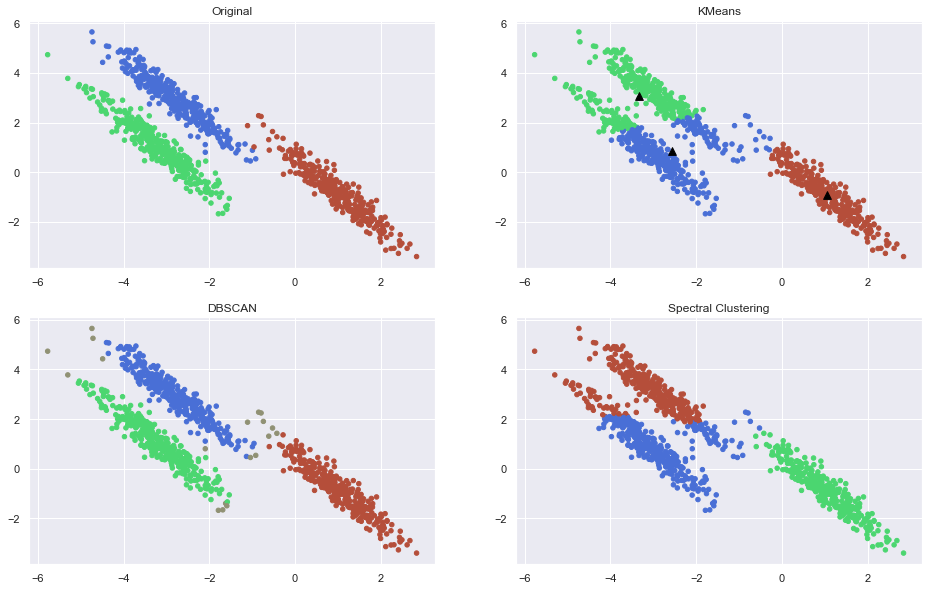

In [12]:
f, ax = plt.subplots(2, 2, figsize=(16, 10));

col_clusters = [colors[i] for i in y]
ax[0, 0].set_title('Original')
ax[0, 0].scatter(X[:, 0], X[:, 1], c=col_clusters, s=20);

km = KMeans(init='k-means++', n_clusters=n_clusters, random_state=random_state)
km.fit(X)

col_clusters = [colors[i] for i in km.labels_]
ax[0, 1].set_title('KMeans')
ax[0, 1].scatter(X[:, 0], X[:, 1], c=col_clusters, s=20);
ax[0, 1].scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], marker='^', c='black', s=60)

model = DBSCAN(eps=eps, min_samples=10)
y_pred = model.fit_predict(X)
col_clusters = [colors[i] for i in y_pred]
ax[1, 0].set_title('DBSCAN')
ax[1, 0].scatter(X[:, 0], X[:, 1], c=col_clusters, s=20);

model = SpectralClustering(n_clusters=n_clusters)
y_pred = model.fit_predict(X)
col_clusters = [colors[i] for i in y_pred]
ax[1, 1].set_title('Spectral Clustering')
ax[1, 1].scatter(X[:, 0], X[:, 1], c=col_clusters, s=20);

In [13]:
sum_ = 0
for i in range(n_clusters):
    cluster = np.where(y == i)[0]
    startC = cluster[0]
    endC = cluster[-1] + 1
    
    if perfect_clusters:
        W[startC:endC, 0:startC] = 0
        W[startC:endC, endC:len(W)] = 0
    
    clusterW = W[startC:endC, startC:endC]
    clusterD = np.diag(np.sum(np.array(clusterW), axis=1))
    clusterL = clusterD - clusterW
    sum_ += np.sum(clusterW)

# sum of edges inside clusters
print(sum_)
# sum of all edges
print(np.sum(W))

26708.22026012456
26723.691710886218


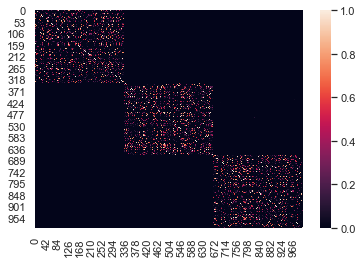

In [14]:
sns.heatmap(W);

In [15]:
# degree matrix
D = np.diag(np.sum(np.array(W), axis=1))
print('degree matrix:')
print(D.shape)
# laplacian matrix
L = D - W
print('laplacian matrix:')
print(L.shape)

degree matrix:
(1000, 1000)
laplacian matrix:
(1000, 1000)


In [16]:
if normalized == 2:
    D = np.diag(np.power(np.diagonal(np.array(D, dtype=float)), -1))
    L = np.dot(D, L)
elif normalized == 3:
    D = np.diag(np.power(np.diagonal(D), -1/2))
    L = np.dot(np.dot(D, L), D)

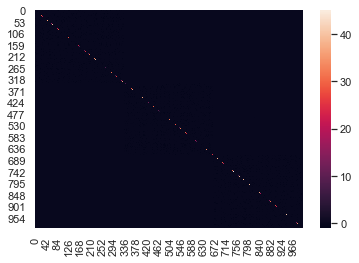

In [17]:
sns.heatmap(L);

In [18]:
vals, vecs = np.linalg.eig(L)
vals = vals.real
vecs = vecs.real
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]

# eigenvalues
print('eigenvalues sorted:')
print(vals[:max_eigenvectors])
print('\neigenvectors')
print(vecs[:max_eigenvectors])

eigenvalues sorted:
[1.03081348e-14 1.30617226e-05 2.80997162e-03 1.83583184e-02
 1.00095925e-01 1.31319320e-01 2.10993552e-01 2.80552167e-01
 2.83734753e-01 3.66124708e-01]

eigenvectors
[[-3.16227766e-02 -9.96789271e-04  2.63090283e-02 ... -4.87184206e-18
  -3.46216455e-14  5.68851409e-14]
 [-3.16227766e-02 -9.96792240e-04  2.63418304e-02 ...  9.57802366e-17
  -6.51799781e-15 -1.10356110e-14]
 [-3.16227766e-02 -9.96658193e-04  2.62514777e-02 ... -1.99382171e-16
  -1.17169599e-09 -2.72159281e-09]
 ...
 [-3.16227766e-02 -9.96786466e-04  2.63272287e-02 ...  6.13481438e-16
   6.08727136e-14  3.77169550e-14]
 [-3.16227766e-02 -9.96788239e-04  2.63329866e-02 ...  4.13910927e-16
   1.99892453e-14  3.80373726e-14]
 [-3.16227766e-02 -9.96705574e-04  2.62784843e-02 ...  7.04783979e-17
   1.53918031e-10  4.36900467e-10]]


In [19]:
if normalized_vecs:
    vecs /= np.power(np.sum(np.power(vecs, 2), axis=1), 1/2)
    print(vecs)

## Before normalization

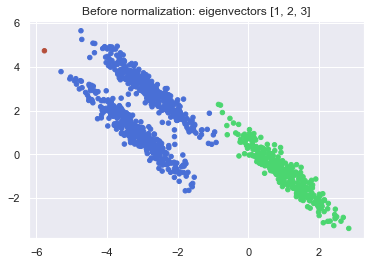

In [20]:
U = vecs[:, real_eigenvecs].reshape(-1, len(eigenvecs))
km = KMeans(init='k-means++', n_clusters=n_clusters, random_state=random_state)
km.fit(U)

col_clusters = [colors[i] for i in km.labels_]
plt.title(f'Before normalization: eigenvectors {eigenvecs}')
plt.scatter(X[:, 0], X[:, 1], c=col_clusters, s=20);

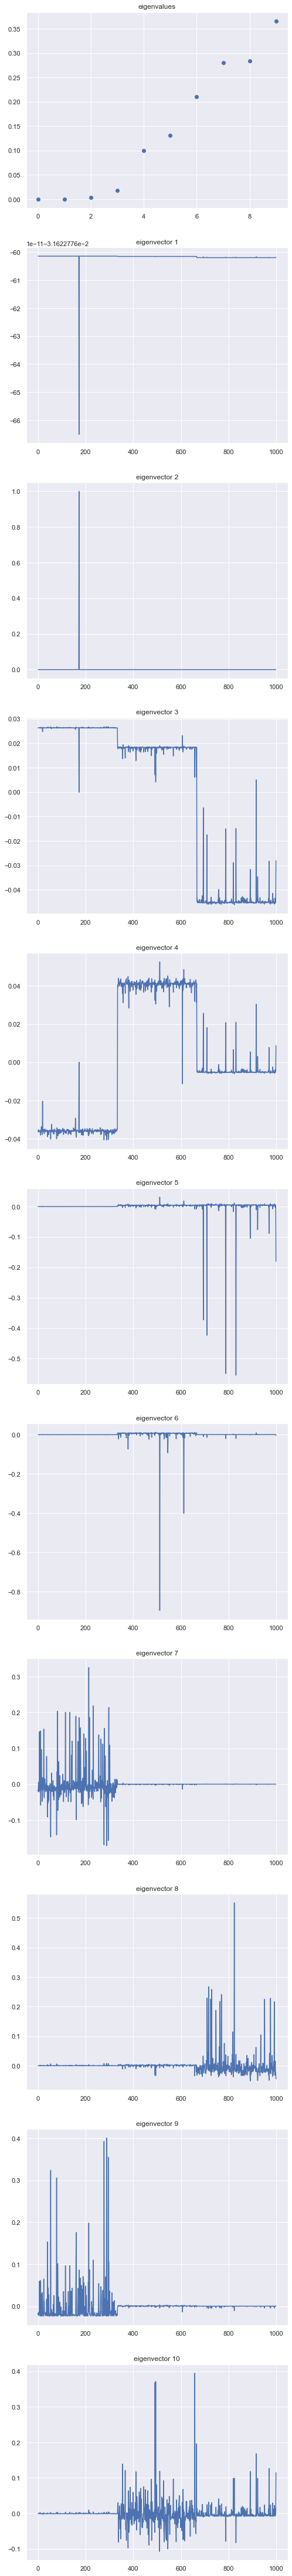

In [21]:
f, ax = plt.subplots(max_eigenvectors + 1, 1, figsize=(8, 8 * max_eigenvectors));

ax[0].set_title('eigenvalues');
ax[0].plot(list(range(max_eigenvectors)), vals[:max_eigenvectors], 'o');

for i in range(max_eigenvectors):
    ax[i + 1].set_title(f'eigenvector {i+1}');
    ax[i + 1].plot(list(range(len(vals))), vecs[:, i]);

## Normalized eigenvectors

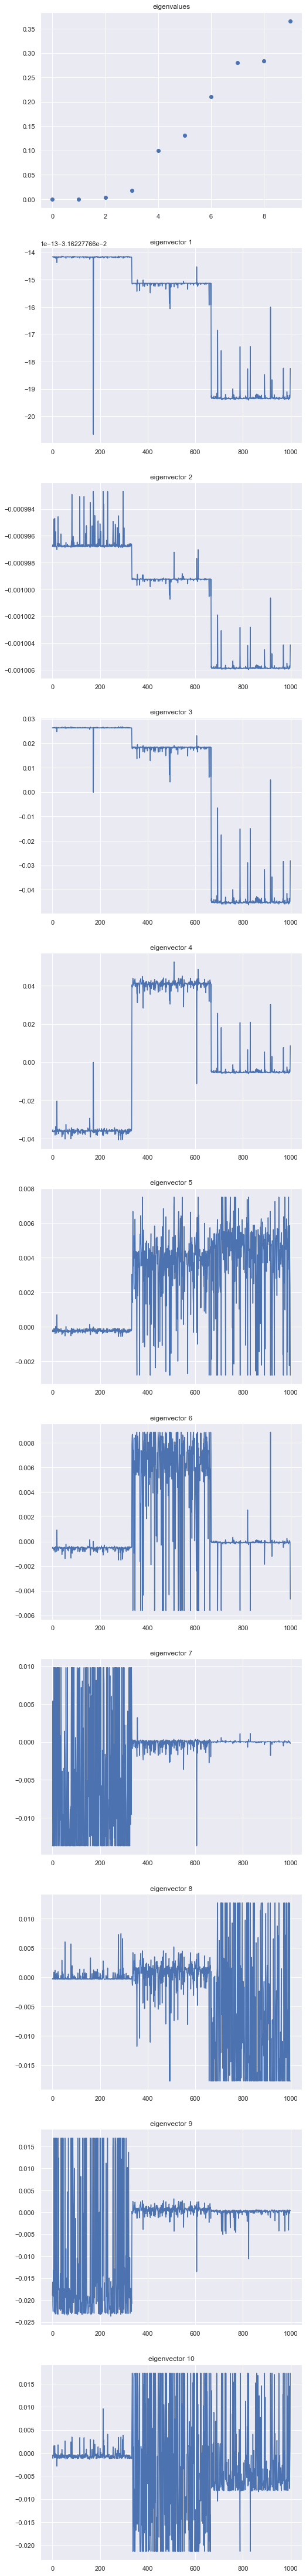

In [22]:
f, ax = plt.subplots(max_eigenvectors + 1, 1, figsize=(8, 8 * max_eigenvectors));

ax[0].set_title('eigenvalues');
ax[0].plot(list(range(max_eigenvectors)), vals[:max_eigenvectors], 'o');

for i in range(max_eigenvectors):
    vec = vecs[:, i]
    
    # remove outliers
    deviation = 2
    vec_ = [0]
    while len(vec_) != len(vec):
        top = np.mean(vec) + deviation * np.std(vec)
        bottom = np.mean(vec) - deviation * np.std(vec)
        vec_ = vec[(vec >= bottom) & (vec <= top)]
        vec[vec > top] = top
        vec[vec < bottom] = bottom

    ax[i + 1].set_title(f'eigenvector {i+1}');
    ax[i + 1].plot(list(range(len(vals))), vec);

## Predicted outputs with normalized eigenvectors

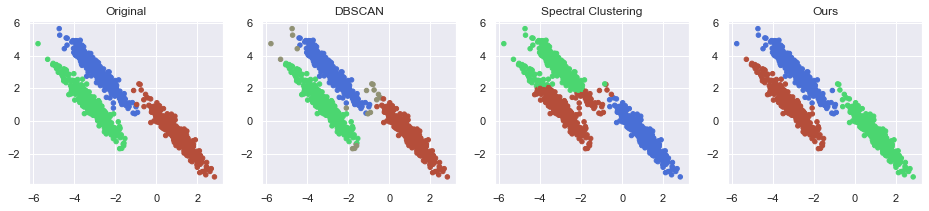

In [23]:
f, ax = plt.subplots(1, 4, figsize=(16, 3));

col_clusters = [colors[i] for i in y]
ax[0].set_title('Original')
ax[0].scatter(X[:, 0], X[:, 1], c=col_clusters, s=20);

model = DBSCAN(eps=eps, min_samples=10)
y_pred = model.fit_predict(X)
col_clusters = [colors[i] for i in y_pred]
ax[1].set_title('DBSCAN')
ax[1].scatter(X[:, 0], X[:, 1], c=col_clusters, s=20);

model = SpectralClustering(n_clusters=n_clusters)
y_pred = model.fit_predict(X)
col_clusters = [colors[i] for i in y_pred]
ax[2].set_title('Spectral Clustering')
ax[2].scatter(X[:, 0], X[:, 1], c=col_clusters, s=20);

U = vecs[:, real_eigenvecs].reshape(-1, len(eigenvecs))
km = KMeans(init='k-means++', n_clusters=n_clusters, random_state=random_state)
km.fit(U)

col_clusters = [colors[i] for i in km.labels_]
ax[3].set_title('Ours')
ax[3].scatter(X[:, 0], X[:, 1], c=col_clusters, s=20);

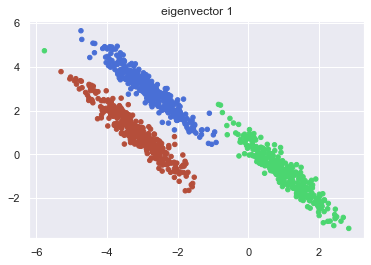

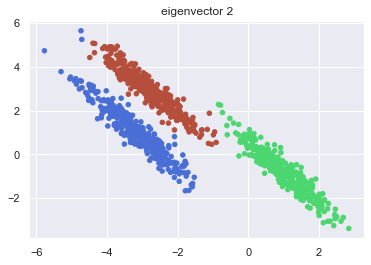

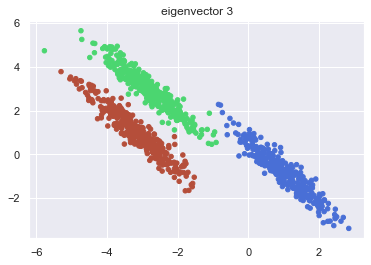

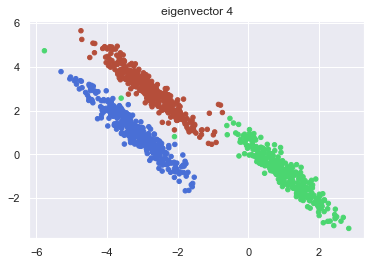

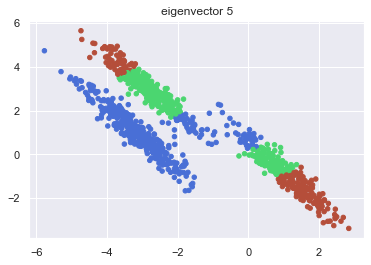

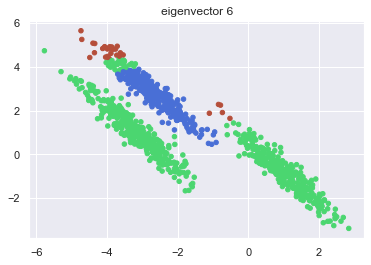

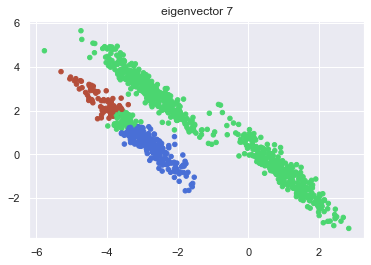

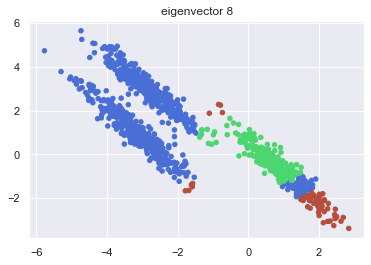

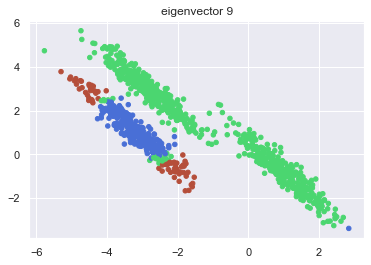

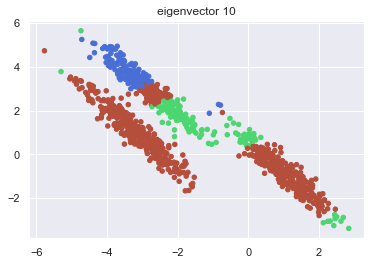

In [24]:
for i in range(max_eigenvectors):
    U = vecs[:, i].reshape(-1, 1)
    km = KMeans(init='k-means++', n_clusters=n_clusters, random_state=random_state)
    km.fit(U)

    col_clusters = [colors[i] for i in km.labels_]

    plt.figure(i)
    plt.title(f'eigenvector {i+1}')
    plt.scatter(X[:, 0], X[:, 1], c=col_clusters, s=20);

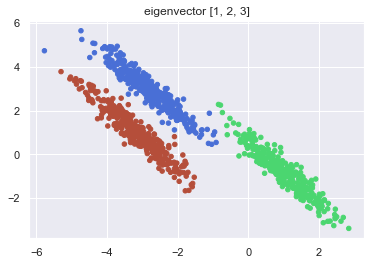

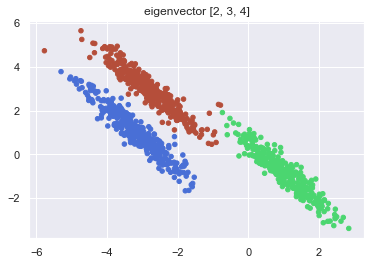

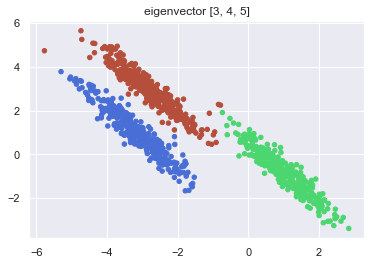

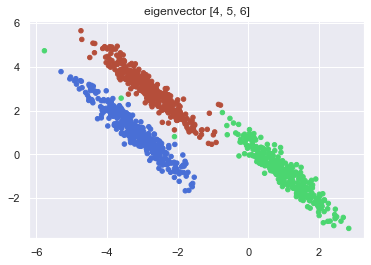

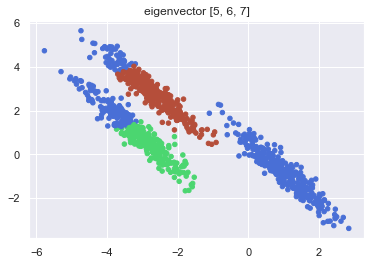

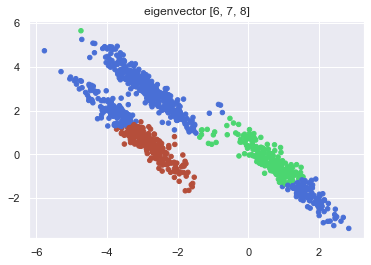

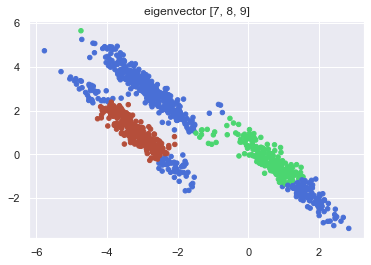

In [25]:
for i in range(max_eigenvectors - len(eigenvecs)):
    vec = [x + i for x in real_eigenvecs]
    U = vecs[:, vec].reshape(-1, len(eigenvecs))
    km = KMeans(init='k-means++', n_clusters=n_clusters, random_state=random_state)
    km.fit(U)

    col_clusters = [colors[i] for i in km.labels_]

    plt.figure(i)
    plt.title(f'eigenvector {[x + i for x in eigenvecs]}')
    plt.scatter(X[:, 0], X[:, 1], c=col_clusters, s=20);

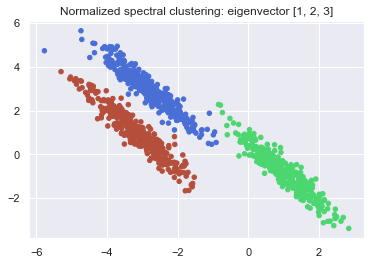

In [26]:
U = vecs[:, real_eigenvecs].reshape(-1, len(eigenvecs))
km = KMeans(init='k-means++', n_clusters=n_clusters, random_state=random_state)
km.fit(U)

col_clusters = [colors[i] for i in km.labels_]
plt.title(f'Normalized spectral clustering: eigenvector {eigenvecs}')
plt.scatter(X[:, 0], X[:, 1], c=col_clusters, s=20);